# Customer Analytics Segmentation Project

## Case Study Description

To what extent does our platform’s acquisition channel influence the learning outcomes of our students?
Are there any geographical locations where most of our students discover the platform, specifically through social media platforms like YouTube or Facebook?

You will work on real-world customer data to perform market segmentation—crucial for businesses to understand customer behavior and improve marketing efficiency. The project will involve data preprocessing, exploratory data analysis (EDA), feature engineering, implementation of clustering algorithms, and interpretation of results. You’ll use two popular clustering techniques: k-means and hierarchical clustering.

In [41]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import os
import shutil

from google.colab import files
from google.colab import drive

drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


## Exploratory Data Analysis

In [42]:
file_path = "/content/drive/MyDrive/MLProcessAZ/Project_Data/customer_segmentation_data.csv"
df = pd.read_csv(file_path)

df.describe()

,minutes_watched,CLV,region,channel
count,3725.000000,3834.000000,3834.000000,3834.000000
mean,1972.094497,118.383920,1.167188,3.870370
std,7401.693028,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,159.000000,62.580000,0.000000,2.000000
50%,512.000000,119.000000,2.000000,3.000000
75%,1521.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


In [43]:
df.describe()

,minutes_watched,CLV,region,channel
count,3725.000000,3834.000000,3834.000000,3834.000000
mean,1972.094497,118.383920,1.167188,3.870370
std,7401.693028,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,159.000000,62.580000,0.000000,2.000000
50%,512.000000,119.000000,2.000000,3.000000
75%,1521.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   minutes_watched  3725 non-null   float64
 1   CLV              3834 non-null   float64
 2   region           3834 non-null   int64  
 3   channel          3834 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 119.9 KB


In [45]:
df_segmentation = df.copy()

In [46]:
df_segmentation.isnull().sum()

,0
minutes_watched,109
CLV,0
region,0
channel,0


In [47]:
df_segmentation = df_segmentation.fillna(0)

In [48]:
df_segmentation.head()

,minutes_watched,CLV,region,channel
0,3197.0,205.42,2,4
1,63.0,149.99,0,1
2,605.0,119.00,2,2
3,20.0,240.00,2,4
4,245.0,184.36,1,4


In [49]:
df_segmentation.dtypes

,0
minutes_watched,float64
CLV,float64
region,int64
channel,int64


###Correlation Matrix

In [50]:
df_segmentation.corr()

,minutes_watched,CLV,region,channel
minutes_watched,1.000000,0.114153,0.040100,-0.003718
CLV,0.114153,1.000000,-0.273312,-0.026359
region,0.040100,-0.273312,1.000000,0.015098
channel,-0.003718,-0.026359,0.015098,1.000000


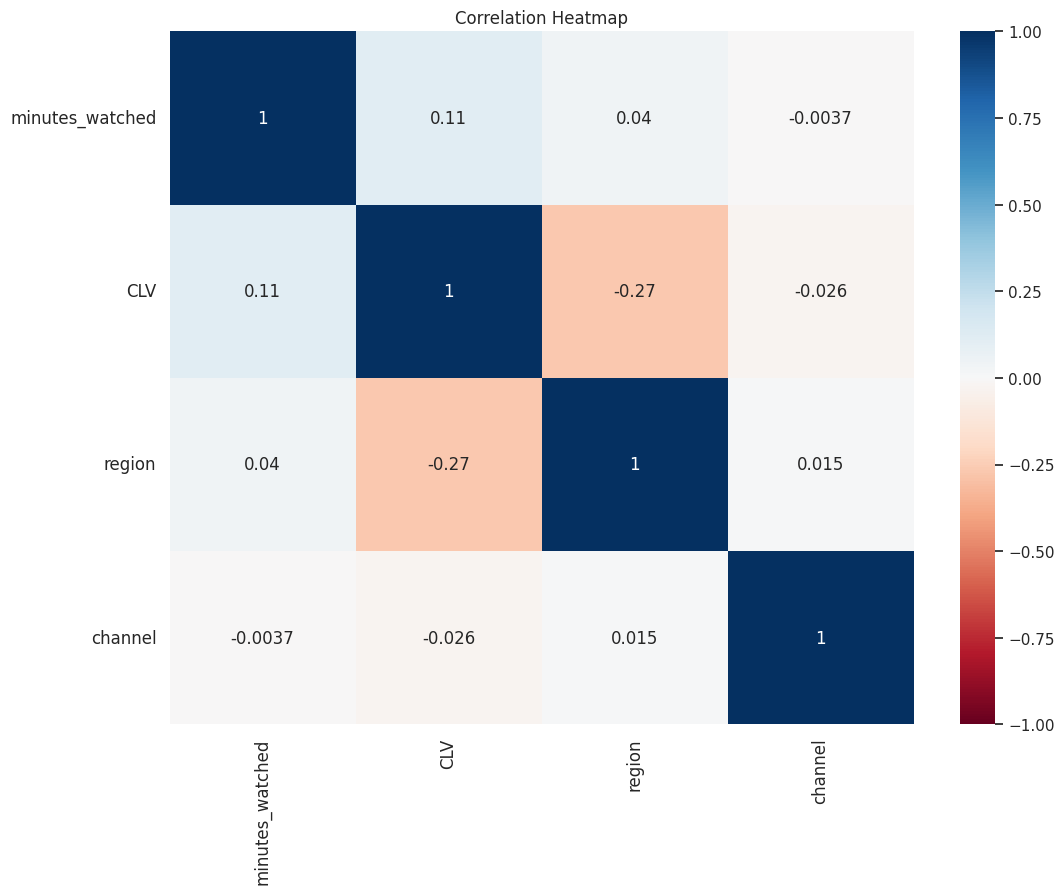

In [51]:
plt.figure(figsize = (12, 9))
mask = np.triu(np.ones_like(df_segmentation.corr(), dtype = bool), k = 1)
s = sns.heatmap(df_segmentation.corr(),
               annot = True,
               cmap = 'RdBu',
               vmin = -1,
               vmax = 1)

s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.savefig('corr.png')
plt.show()

#No features appear too correlated with each other

### Data Visualization

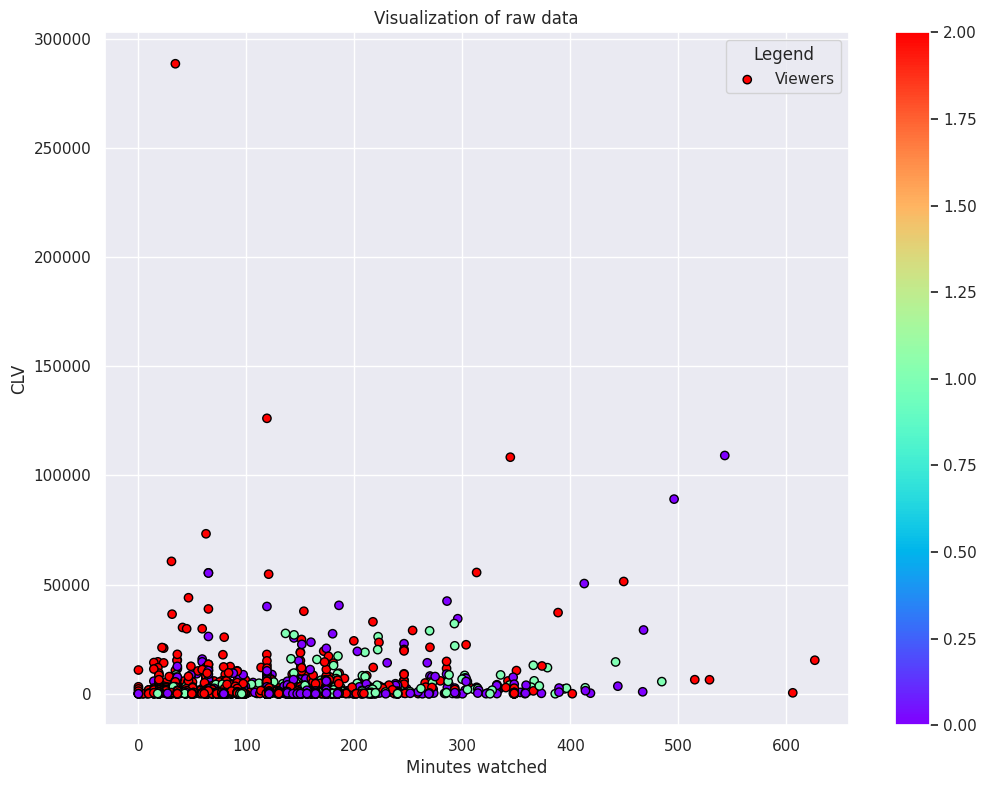

In [52]:
plt.figure(figsize = (12, 9))

# Plotting minutes_watched and clv

plt.scatter(df_segmentation.iloc[:, 1], df_segmentation.iloc[:, 0], c = df_segmentation["region"],edgecolor = "black", cmap = "rainbow", label = "Viewers")
plt.xlabel('Minutes watched')
plt.ylabel('CLV')
plt.title('Visualization of raw data')
plt.savefig("scatter.png")
plt.legend(title = "Legend")
plt.colorbar()
plt.show()

#The large range of the minutes_watched variable shows that we probably should standardize our data to prevent skewed clustering

### Dummy Variables

In [53]:
df_heard_from = df_segmentation['channel']

In [54]:
df_countries = df_segmentation['region']

In [55]:
# One hot encoding

df_dummies = pd.get_dummies(df['channel'].apply(pd.Series).stack())
df_dummies = df_dummies.groupby(level=0).sum()
df = df.join(df_dummies)

In [56]:
segment_dummies = pd.get_dummies(df_heard_from, prefix = 'channel', prefix_sep = '_')
df_segmentation = pd.concat([df_segmentation, segment_dummies], axis = 1)

In [57]:
# Same approached for regions

segment_dummies_2 = pd.get_dummies(df_countries, prefix = 'country_region', prefix_sep = '_')
df_segmentation = pd.concat([df_segmentation, segment_dummies_2], axis = 1)

In [58]:
# dropping the channel variable as it is non-numerical and it'll not be able to perform the segmentation

df_segmentation = df_segmentation.drop(["channel"], axis = 1)

In [59]:
df_segmentation

,minutes_watched,CLV,region,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,country_region_0,country_region_1,country_region_2
0,3197.0,205.42,2,False,False,False,True,False,False,False,False,False,False,True
1,63.0,149.99,0,True,False,False,False,False,False,False,False,True,False,False
2,605.0,119.00,2,False,True,False,False,False,False,False,False,False,False,True
3,20.0,240.00,2,False,False,False,True,False,False,False,False,False,False,True
4,245.0,184.36,1,False,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,0,False,False,True,False,False,False,False,False,True,False,False
3830,28.0,79.00,0,False,True,False,False,False,False,False,False,True,False,False
3831,57.0,36.00,2,False,True,False,False,False,False,False,False,False,False,True
3832,44.0,36.00,2,True,False,False,False,False,False,False,False,False,False,True


In [60]:
# renaming the columns after adding the dummie variables
df_segmentation = df_segmentation.rename(columns = {'channel_1':'Google', 'channel_2':'Facebook', 'channel_3':'YouTube','channel_4':'LinkedIn',
                                                    'channel_5':'Twitter', 'channel_6':'Instagram', 'channel_7':'Friend', 'channel_8':'Other',
                                                    'country_region_0':'Region_0','country_region_1':'Region_1','country_region_2':'Region_2'})

In [61]:
df_segmentation

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2
0,3197.0,205.42,2,False,False,False,True,False,False,False,False,False,False,True
1,63.0,149.99,0,True,False,False,False,False,False,False,False,True,False,False
2,605.0,119.00,2,False,True,False,False,False,False,False,False,False,False,True
3,20.0,240.00,2,False,False,False,True,False,False,False,False,False,False,True
4,245.0,184.36,1,False,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,0,False,False,True,False,False,False,False,False,True,False,False
3830,28.0,79.00,0,False,True,False,False,False,False,False,False,True,False,False
3831,57.0,36.00,2,False,True,False,False,False,False,False,False,False,False,True
3832,44.0,36.00,2,True,False,False,False,False,False,False,False,False,False,True


## Model Implementation

### Standardization

In [62]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df_segmentation)

In [63]:
hier_clust = linkage(segmentation_std, method = 'ward')

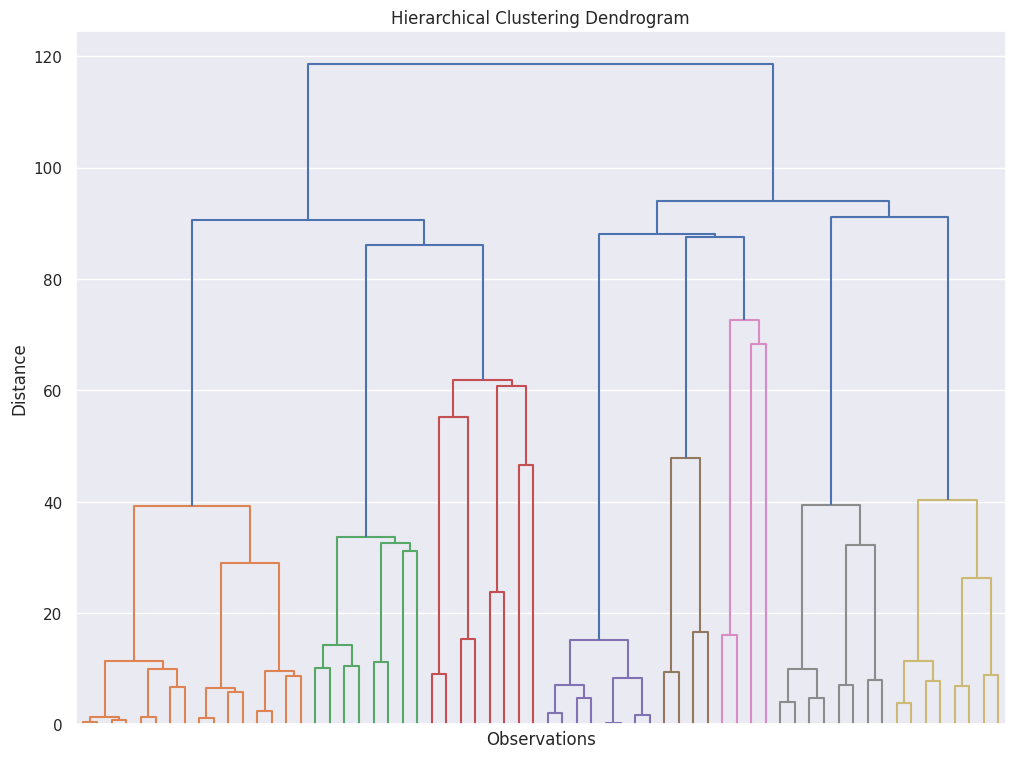

In [64]:
plt.figure(figsize = (12,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')

dendrogram(hier_clust,
           truncate_mode = 'level',
           p = 5,
           show_leaf_counts = False,
           no_labels = True)

plt.savefig('hierarchical.png')

plt.show()

### K-means Clustering

In [65]:
#Keeping track of inertia_ for elbow method

wcss = []

for i in range(1,11):

    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)

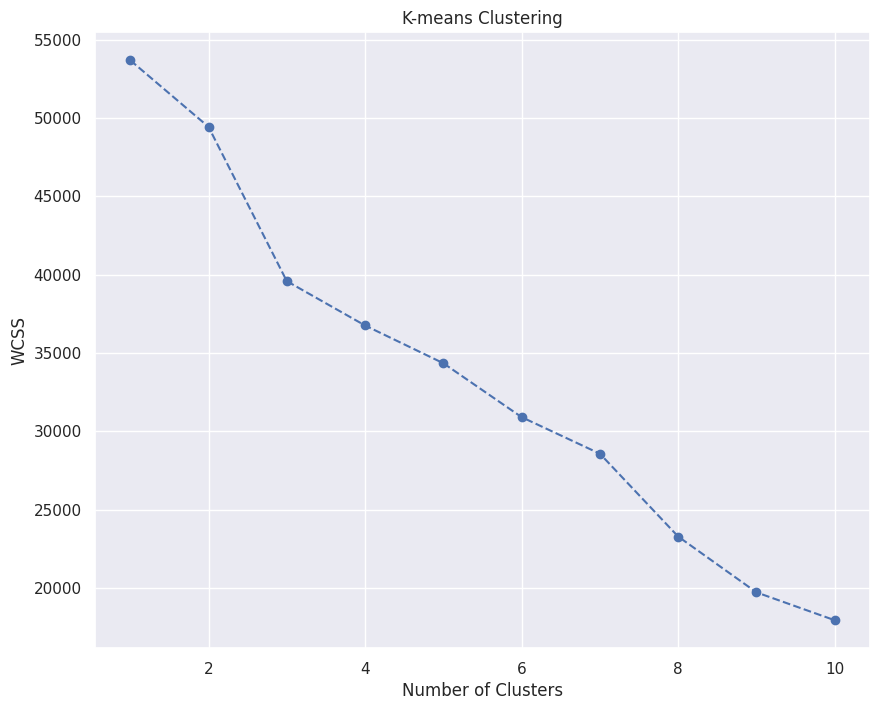

In [66]:
plt.figure(figsize = (10,8))

# Plotting the WCSS values against the number of clusters.

plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.savefig('line_chart.png')
plt.show()

In [67]:
kmeans = KMeans(n_clusters = 8, init = 'k-means++', random_state = 42)

In [68]:
kmeans.fit(segmentation_std)

KMeans(random_state=42)

## Model Interpretation and Results

In [69]:
df_segm_kmeans = df_segmentation.copy()
df_segm_kmeans['Segment'] = kmeans.labels_

In [70]:
pd.set_option('display.max_columns', 500)

In [71]:
df_segm_analysis = df_segm_kmeans.groupby(['Segment']).mean()
df_segm_analysis

# Grouping the dataframe by the 'Segment' column and calculating the mean for each segment.
# This will provides profile for each cluster based on the mean values of the original features.

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2
Segment,,,,,,,,,,,,,,
0,2767.643791,108.260359,1.323529,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.287582,0.101307,0.611111
1,1539.152607,136.329469,0.000000,0.248341,0.0,0.432227,0.179147,0.0,0.0,0.0,0.140284,1.000000,0.000000,0.000000
2,1763.190889,100.376616,1.848156,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.151844,0.848156
3,1800.537897,111.313594,1.801956,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.198044,0.801956
4,2486.479434,118.394974,1.785347,0.000000,0.0,0.820051,0.000000,0.0,0.0,0.0,0.179949,0.000000,0.214653,0.785347
5,2006.190377,113.654038,1.372385,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.257322,0.112971,0.629707
6,985.327586,93.151552,1.603448,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.172414,0.051724,0.775862
7,1299.332180,115.180277,1.186851,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.311419,0.190311,0.498270


In [72]:
df_segm_analysis['N Obs'] = df_segm_kmeans[['Segment','Region_0']].groupby(['Segment']).count()
df_segm_analysis['Prop Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()

#Here, we're trying to gain an idea of the manner in which each cluster has split the different observations, by grouping in terms of segment and taking their count and proportion
#respectively

In [73]:
df_segm_analysis.round(2)

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2,N Obs,Prop Obs
Segment,,,,,,,,,,,,,,,,
0,2767.64,108.26,1.32,0.00,1.0,0.00,0.00,0.0,0.0,0.0,0.00,0.29,0.10,0.61,306,0.08
1,1539.15,136.33,0.00,0.25,0.0,0.43,0.18,0.0,0.0,0.0,0.14,1.00,0.00,0.00,1055,0.28
2,1763.19,100.38,1.85,0.00,0.0,0.00,1.00,0.0,0.0,0.0,0.00,0.00,0.15,0.85,461,0.12
3,1800.54,111.31,1.80,1.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.20,0.80,409,0.11
4,2486.48,118.39,1.79,0.00,0.0,0.82,0.00,0.0,0.0,0.0,0.18,0.00,0.21,0.79,778,0.20
5,2006.19,113.65,1.37,0.00,0.0,0.00,0.00,0.0,0.0,1.0,0.00,0.26,0.11,0.63,478,0.12
6,985.33,93.15,1.60,0.00,0.0,0.00,0.00,1.0,0.0,0.0,0.00,0.17,0.05,0.78,58,0.02
7,1299.33,115.18,1.19,0.00,0.0,0.00,0.00,0.0,1.0,0.0,0.00,0.31,0.19,0.50,289,0.08


In [74]:
df_segm_analysis.rename({0:'Facebook Followers',
                         1:'Google-YouTube Mix',
                         2:'LinkedIn Networkers',
                         3:'Google-Mix',
                         4:'Other/Youtube',
                         5:'Through Friends',
                         6:'Twitter Devotees',
                         7:'Instagram Explorers',
                        })

,minutes_watched,CLV,region,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2,N Obs,Prop Obs
Segment,,,,,,,,,,,,,,,,
Facebook Followers,2767.643791,108.260359,1.323529,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.287582,0.101307,0.611111,306,0.079812
Google-YouTube Mix,1539.152607,136.329469,0.000000,0.248341,0.0,0.432227,0.179147,0.0,0.0,0.0,0.140284,1.000000,0.000000,0.000000,1055,0.275170
LinkedIn Networkers,1763.190889,100.376616,1.848156,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.151844,0.848156,461,0.120240
Google-Mix,1800.537897,111.313594,1.801956,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.198044,0.801956,409,0.106677
Other/Youtube,2486.479434,118.394974,1.785347,0.000000,0.0,0.820051,0.000000,0.0,0.0,0.0,0.179949,0.000000,0.214653,0.785347,778,0.202921
Through Friends,2006.190377,113.654038,1.372385,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.257322,0.112971,0.629707,478,0.124674
Twitter Devotees,985.327586,93.151552,1.603448,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.172414,0.051724,0.775862,58,0.015128
Instagram Explorers,1299.332180,115.180277,1.186851,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.311419,0.190311,0.498270,289,0.075378


In [75]:
#Based on data given in the legend

df_segm_kmeans['Labels'] = df_segm_kmeans['Segment'].map({0:'Facebook Followers',
                         1:'Google-YouTube Mix',
                         2:'LinkedIn Networkers',
                         3:'Google-Mix',
                         4:'Other/Youtube',
                         5:'Through Friends',
                         6:'Twitter Devotees',
                         7:'Instagram Explorers',
                        })

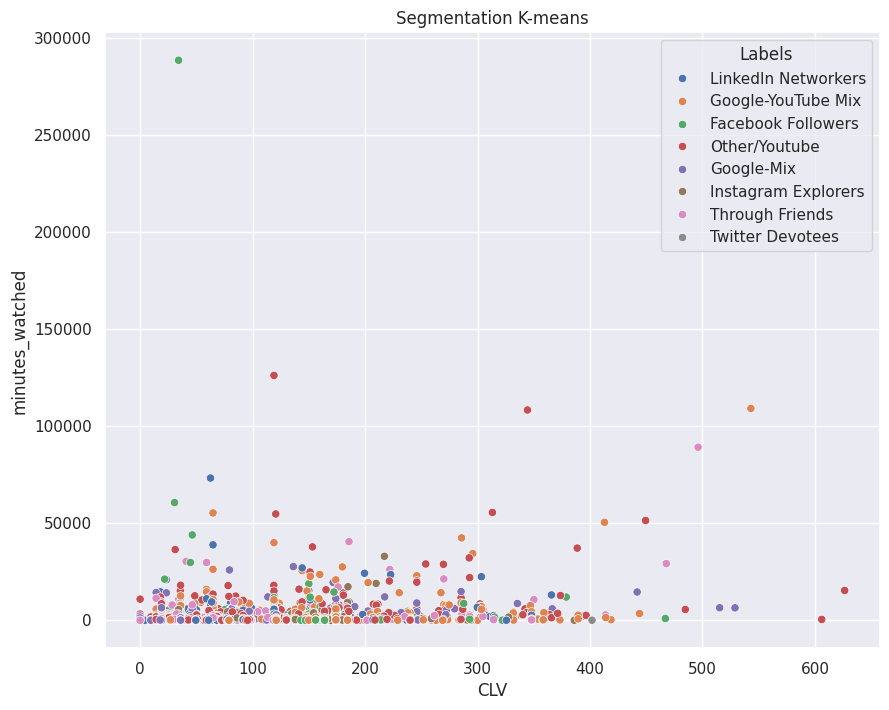

In [76]:
x_axis = df_segm_kmeans['CLV']
y_axis = df_segm_kmeans['minutes_watched']

# Setting the figure size for the scatter plot.
plt.figure(figsize = (10, 8))

# Creating a scatter plot using seaborn.
# The 'hue' parameter colors the points based on the 'Labels' column, allowing for distinction between clusters.
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm_kmeans['Labels'])

# Setting the title of the scatter plot.
plt.title('Segmentation K-means')

# Displaying the scatter plot.
plt.show()